<a href="https://colab.research.google.com/github/goodu001/lazada_astaxanthin_scatter_plot/blob/main/lazada_astaxanthin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports & setup (Jupyter-ready)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Optional grid display for certain environments (e.g., ChatGPT UI)
try:
    from caas_jupyter_tools import display_dataframe_to_user
    HAVE_CJ = True
except Exception:
    HAVE_CJ = False

print('Libraries ready.')

Libraries ready.


In [6]:
# --- Cell 2 (Colab + .gsheet shortcut resolver) ---

# 1) Mount Google Drive (ข้อความ "already mounted" ไม่ใช่ error, ข้ามได้)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# 2) Auth for Drive & Sheets
from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()

# 3) Drive API client + gspread
try:
    from googleapiclient.discovery import build
except Exception:
    !pip -q install google-api-python-client
    from googleapiclient.discovery import build

try:
    import gspread
except Exception:
    !pip -q install gspread
    import gspread

service = build('drive', 'v3', cache_discovery=False)
gc = gspread.authorize(creds)

# 4) Path you requested
from pathlib import Path
import pandas as pd
DATA_PATH = Path('/content/drive/MyDrive/lazada_astaxanthin_allpages.gsheet')
print('Using file:', DATA_PATH)

# 5) Helper: resolve a .gsheet shortcut -> target spreadsheet, then load
def load_from_gsheet_shortcut(shortcut_path: Path) -> pd.DataFrame:
    """
    Resolve a Google Drive .gsheet shortcut to the real spreadsheet and load as DataFrame.
    Strategy:
      - Find the file by its name (with and without .gsheet)
      - If it's a shortcut, fetch shortcutDetails.targetId
      - If target is a spreadsheet => use gspread to read first worksheet as records
    """
    # Search by name (both with .gsheet and stem)
    name_candidates = [shortcut_path.name, shortcut_path.stem]

    q_names = " or ".join([f"name = '{n}'" for n in name_candidates])
    query = f"({q_names}) and trashed = false"

    resp = service.files().list(
        q=query,
        fields="files(id, name, mimeType)",
        supportsAllDrives=True,
        includeItemsFromAllDrives=True
    ).execute()

    files = resp.get('files', [])
    if not files:
        raise RuntimeError(f"Cannot find file in Drive by names: {name_candidates}")

    f = files[0]  # take the first match
    mime = f['mimeType']

    # If it's a shortcut, resolve to target
    if mime == 'application/vnd.google-apps.shortcut':
        meta = service.files().get(
            fileId=f['id'],
            fields="id, name, shortcutDetails",
            supportsAllDrives=True
        ).execute()
        sc = meta.get('shortcutDetails', {})
        target_id = sc.get('targetId')
        target_mime = sc.get('targetMimeType')
    else:
        target_id = f['id']
        target_mime = mime

    # If target is a Google Sheet -> use gspread
    if target_mime == 'application/vnd.google-apps.spreadsheet':
        sh = gc.open_by_key(target_id)
        # pick first worksheet (you can change index if needed)
        ws = sh.get_worksheet(0)
        rows = ws.get_all_records()  # uses first row as header
        df = pd.DataFrame(rows)
        print(f"Loaded via gspread from worksheet: {ws.title}  (rows={len(rows)})")
        return df

    # Otherwise, try to use export CSV (if file is public/shared accordingly)
    # (Usually not needed for your case, but left as a fallback.)
    try:
        csv_url = f"https://docs.google.com/uc?export=download&id={target_id}"
        df = pd.read_csv(csv_url)
        print("Loaded via CSV export URL.")
        return df
    except Exception as e:
        raise RuntimeError(f"Unsupported target mimeType or permissions issue: {target_mime}. Error: {e}")

# 6) Decide how to read based on suffix; .gsheet -> resolver
if DATA_PATH.suffix.lower() == '.gsheet':
    df = load_from_gsheet_shortcut(DATA_PATH)
else:
    # If you later switch to a plain CSV path, this will handle it
    df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
print('Columns:', list(df.columns))

# Preview first 50 rows (fallback if display_dataframe_to_user is unavailable)
try:
    if 'display_dataframe_to_user' in globals() and HAVE_CJ:
        display_dataframe_to_user('Raw preview (first 50 rows)', df.head(50))
    else:
        display(df.head(50))
except Exception:
    display(df.head(50))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using file: /content/drive/MyDrive/lazada_astaxanthin_allpages.gsheet
Loaded via gspread from worksheet: lazada_astaxanthin_allpages  (rows=1407)
Shape: (1407, 9)
Columns: ['product_id', 'name', 'price_text', 'price', 'sold_text', 'sold_est', 'rating_text', 'reviews_text', 'product_url']


,product_id,name,price_text,price,sold_text,sold_est,rating_text,reviews_text,product_url
0,438,Omilay Astaxanthin Gummy อุดมไปด้วย วิตามินซี ...,฿189.00,189.00,(0)กรุงเทพมหานคร,0,,,https://www.lazada.co.th/products/pdp-i5749156...
1,750,[พร้อมส่ง + แท้100% + เก็บเงินปลายทางได้] Vist...,฿419.00,419.00,(0)นครราชสีมา,0,,,https://www.lazada.co.th/products/pdp-i2078620...
2,949,Red Diamond Astaxanthin 1 กระปุก แอสต้าแซนริน ...,฿399.00,399.00,(0)ขอนแก่น,0,,,https://www.lazada.co.th/products/pdp-i5519199...
3,1313,BioActive+Conentrated Liquid Asta Drink Astaxa...,"฿1,990.00",1990.00,(0)เชียงราย,0,,,https://www.lazada.co.th/products/pdp-i5840798...
4,26,แอสตาแซนธิน - ดูดซึมได้สูง - การเผาผลาญและสุขภ...,฿165.45,165.45,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5747083...
5,54,30/60/120 แคปซูล แอสตาแซนธิน + ไลโคปีน - เพิ่ม...,฿83.50,83.50,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5829973...
6,123,แอสทาแคริน - บำรุงสุขภาพหัวใจและหลอดเลือด - ระ...,฿162.00,162.00,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5796019...
7,139,อาหารเสริมแอสตาแซนธิน Tecepec ประกอบด้วยแอสตาแ...,฿140.27,140.27,(1)ลำพูน,1,,,https://www.lazada.co.th/products/pdp-i5816636...
8,146,Tecepec Astaxanthin 4 มก. ส่งเสริมการฟื้นฟูการ...,฿155.00,155.00,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5617913...
9,151,COOLKIN Astaxanthin Elite 120 เม็ด | ช่วยเพิ่ม...,฿45.00,45.00,(1)เชียงใหม่,1,,,https://www.lazada.co.th/products/pdp-i5852433...


In [7]:
import re
import numpy as np

def _to_float(text):
    """Extracts a float from a string; handles ranges like '149-199' by taking the mean."""
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return np.nan
    s = str(text).strip()
    if s == '' or s.lower() in {'nan', 'none', 'null', '-'}:
        return np.nan
    s = s.replace('฿','').replace(',','')
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('–','-').replace('—','-')
    if '-' in s and any(ch.isdigit() for ch in s):
        parts = [p for p in s.split('-') if any(ch.isdigit() for ch in p)]
        nums = []
        for p in parts:
            m = re.search(r'(\d+(\.\d+)?)', p)
            if m:
                nums.append(float(m.group(1)))
        if nums:
            return float(np.mean(nums))
    m = re.search(r'(\d+(\.\d+)?)', s)
    return float(m.group(1)) if m else np.nan

def parse_price(x):
    """Convert price-like text to numeric float (THB)."""
    try:
        return _to_float(x)
    except Exception:
        return np.nan

def parse_number_with_suffix(x):
    """Parse counts like 1.2k or '1,234 sold' into a numeric float."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).strip().lower()
    s = s.replace('+','')
    if s == '' or s in {'nan','none','null','-'}:
        return np.nan
    # already numeric?
    try:
        return float(s)
    except ValueError:
        pass
    # '1.2k' / '3m'
    m = re.match(r'^\s*(\d+(\.\d+)?)([kKmM])\s*$', s)
    if m:
        val = float(m.group(1))
        suf = m.group(3).lower()
        if suf == 'k':
            return val * 1_000
        if suf == 'm':
            return val * 1_000_000
    # '1,234 sold', 'sold 1.2k'
    m = re.search(r'(\d{1,3}(?:,\d{3})+|\d+(\.\d+)?)', s)
    if m:
        return float(m.group(0).replace(',',''))
    return np.nan

print("Helpers ready.")


Helpers ready.


In [8]:
def pick_col(df, candidates):
    for c in candidates:
        for col in df.columns:
            if col.lower().strip() == c:
                return col
    return None

name_col = pick_col(df, ['name','product_name','title'])
price_col = pick_col(df, ['price','price_thb','price_text'])
sold_col  = pick_col(df, ['sold_est','sold_vol','sold','sold_estimated','sold_count','sold_qty'])

print('Detected -> name:', name_col, '| price:', price_col, '| sold:', sold_col)

df_work = df.copy()

# Price to numeric
if price_col:
    if price_col == 'price' and pd.api.types.is_numeric_dtype(df_work[price_col]):
        df_work['price_num'] = df_work[price_col].astype(float)
    else:
        df_work['price_num'] = df_work[price_col].apply(parse_price)
else:
    df_work['price_num'] = np.nan

# Sold to numeric
if sold_col:
    df_work['sold_num'] = df_work[sold_col].apply(parse_number_with_suffix)
else:
    df_work['sold_num'] = np.nan

cleaned = pd.DataFrame({
    'name': df_work[name_col] if name_col else df_work.index.astype(str),
    'price': df_work['price_num'],
    'sold_est': df_work['sold_num'],
})

before = cleaned.shape[0]
cleaned = cleaned.dropna(subset=['price','sold_est'])
cleaned = cleaned[(cleaned['price'] > 0) & (cleaned['sold_est'] >= 0)].reset_index(drop=True)
after = cleaned.shape[0]

print(f'Rows before cleaning: {before}  |  after: {after}')
display(cleaned.describe(include='all'))

# Preview cleaned tables (Top 50 & Top 30 by sold_est)
try:
    if 'display_dataframe_to_user' in globals() and HAVE_CJ:
        display_dataframe_to_user('Cleaned data (first 50 rows)', cleaned.head(50))
        display_dataframe_to_user('Top 30 by sold_est', cleaned.sort_values('sold_est', ascending=False).head(30))
    else:
        display(cleaned.head(50))
        display(cleaned.sort_values('sold_est', ascending=False).head(30))
except Exception:
    display(cleaned.head(50))
    display(cleaned.sort_values('sold_est', ascending=False).head(30))


Detected -> name: name | price: price | sold: sold_est
Rows before cleaning: 1407  |  after: 1407


,name,price,sold_est
count,1407,1407.000000,1407.000000
unique,1318,NaN,NaN
top,Nectapharma Luminari Astaxanthin ลูมินารี่ แอส...,NaN,NaN
freq,4,NaN,NaN
mean,NaN,708.200604,711.799574
std,NaN,699.017929,6357.309457
min,NaN,11.000000,0.000000
25%,NaN,229.000000,0.000000
50%,NaN,450.000000,2.000000
75%,NaN,979.000000,52.500000


,name,price,sold_est
0,Omilay Astaxanthin Gummy อุดมไปด้วย วิตามินซี ...,189.00,0.0
1,[พร้อมส่ง + แท้100% + เก็บเงินปลายทางได้] Vist...,419.00,0.0
2,Red Diamond Astaxanthin 1 กระปุก แอสต้าแซนริน ...,399.00,0.0
3,BioActive+Conentrated Liquid Asta Drink Astaxa...,1990.00,0.0
4,แอสตาแซนธิน - ดูดซึมได้สูง - การเผาผลาญและสุขภ...,165.45,1.0
5,30/60/120 แคปซูล แอสตาแซนธิน + ไลโคปีน - เพิ่ม...,83.50,1.0
6,แอสทาแคริน - บำรุงสุขภาพหัวใจและหลอดเลือด - ระ...,162.00,1.0
7,อาหารเสริมแอสตาแซนธิน Tecepec ประกอบด้วยแอสตาแ...,140.27,1.0
8,Tecepec Astaxanthin 4 มก. ส่งเสริมการฟื้นฟูการ...,155.00,1.0
9,COOLKIN Astaxanthin Elite 120 เม็ด | ช่วยเพิ่ม...,45.00,1.0


,name,price,sold_est
792,Dr.PONG Astaxanthin 6 mg AstaREAL from Japan ด...,379.0,100400.0
795,Brightening body moisturizer,379.0,100400.0
794,popmart figure,379.0,100400.0
793,Lupo designer bag,379.0,100400.0
791,Dr.Pong Astaxanthin 6 mg AstaREAL from Japan แ...,379.0,90700.0
790,Vsea Astaxanthin น้ำพิเศษต่อต้านอนุมูลอิสระ กร...,140.0,65000.0
789,VISTRA Coenzyme Q10 30 mg - วิสทร้า โคเอนไซม์ ...,245.0,31900.0
788,Nectapharma Luminari Astaxanthin ลูมินารี่ แอส...,1190.0,24100.0
787,ทรายแมวเต้าหู้ ทรายเต้าหู้ ออร์แกนิค100% ผลิตจ...,49.0,22500.0
786,VISTRA ASTAXANTHIN 6 MG PLUS VITAMIN E วิสทร้า...,880.0,20900.0


/tmp/ipython-input-3982382197.py:23: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3982382197.py:23: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3982382197.py:23: UserWarning: Glyph 3635 (\N{THAI CHARACTER SARA AM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3982382197.py:23: UserWarning: Glyph 3614 (\N{THAI CHARACTER PHO PHAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3982382197.py:23: UserWarning: Glyph 3636 (\N{THAI CHARACTER SARA I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3982382197.py:23: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3982382197.py:23: UserWarning: Glyph 3624 (\N{THAI CHARACTER SO SALA}) missing from font(s) DejaVu Sans.
  plt.tig

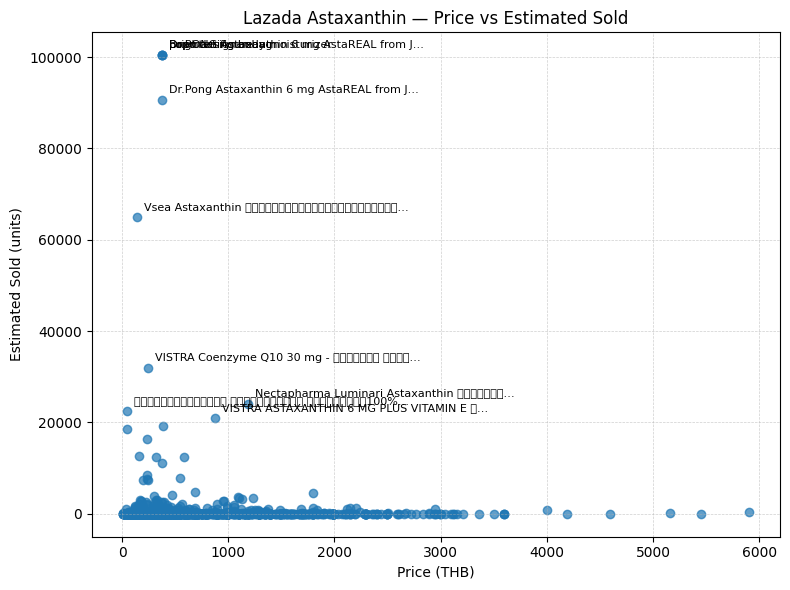

Figure saved to: /content/astaxanthin_scatter.png


In [9]:
from pathlib import Path

if cleaned.empty:
    print("No rows to plot after cleaning.")
else:
    plt.figure(figsize=(8, 6))
    plt.scatter(cleaned['price'], cleaned['sold_est'], alpha=0.7)
    plt.xlabel('Price (THB)')
    plt.ylabel('Estimated Sold (units)')
    plt.title('Lazada Astaxanthin — Price vs Estimated Sold')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

    # Label top 10 by sold_est
    to_label = cleaned.nlargest(10, 'sold_est')
    for _, row in to_label.iterrows():
        label = row['name']
        if isinstance(label, str) and len(label) > 40:
            label = label[:40] + '…'
        plt.annotate(label, (row['price'], row['sold_est']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

    out_png = Path('astaxanthin_scatter.png')  # saved alongside the notebook
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    print('Figure saved to:', out_png.resolve())


In [10]:
from pathlib import Path

out_csv = Path('lazada_astaxanthin_cleaned.csv')
cleaned.to_csv(out_csv, index=False)
print('Cleaned CSV saved to:', out_csv.resolve())


Cleaned CSV saved to: /content/lazada_astaxanthin_cleaned.csv
